# Comparison Between RNN and CNN on EEG data
Attempt at implementing RNN and CNN models on BCI Competition IV 2a Dataset
  


# BCI Competition IV Dataset 2a (.npz data)
Information Given in Documentation

From the documentation it is known that:
* 25 electrodes are used, first 22 are EEG, last 3 are EOG
* Sampling frequency (fs) is 250Hz
* 9 subjects
* 9 run (run 1-3 are for eye movement, run 4-9 is MI)  
  

**-- Time Duration--**  
1 trials                          = 7-8s  
1 run              = 48 trials    = 336-384s  
1 session = 6 runs = 288 trials   = 2016-2304s

About the recording of eye movement
* run 1 => 2 mins with eyes open
* run 2 => 1 min with eyes closed
* run 3 => 1 min with eye movements

![timing-scheme-paradigm.png](https://github.com/orvindemsy/BCICIV2a-FBCSP/blob/master/img/timing-scheme-paradigm.png?raw=1)

In [ ]:
!pip install mne

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from scipy import signal
import mne
import os
from matplotlib import pyplot as plt
from mne.datasets import sample
from mne.preprocessing import EOGRegression
import matplotlib.pyplot as plt
import pandas
from scipy.signal import spectrogram
import torch.nn as nn
import tensorflow as tf
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from keras.utils import to_categorical

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# tools for plotting confusion matrices
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
!git clone https://github.com/vlawhern/arl-eegmodels.git
%cd arl-eegmodels
from EEGModels import EEGNet


fatal: destination path 'arl-eegmodels' already exists and is not an empty directory.
/content/arl-eegmodels


# Loading dataset

In [ ]:
# Clone the repository
!git clone https://github.com/orvindemsy/BCICIV2a-FBCSP.git

# Navigate to the folder (if needed)
%cd BCICIV2a-FBCSP/datasets

fatal: destination path 'BCICIV2a-FBCSP' already exists and is not an empty directory.
/content/arl-eegmodels/BCICIV2a-FBCSP/datasets


In [ ]:
# First import the data

# Number of subject, n + 1 for iteration purpose (there are 9 subjects)
ns = 10

# Creating dict to store original data and modified data
# ori_data will serve as initial loaded data that will remain unchanged
# mod_data will contain modified original data
ori_data = dict()
mod_data = dict()

In [ ]:
# Function to count subject
def subject_counter(i):
    return 'subject0{}'.format(i)

In [ ]:
# Path manipulation if running in dev container
if os.getcwd() == '/':
    print("Running the notebook it inside dev container..")
    base_dir = os.environ["DOCKER_WORKDIR"]
else:
    print("Running the notebook locally..")
    base_dir = os.getcwd()

Running the notebook locally..


In [ ]:
# Load the training data of all subjects

# Iter over all data path then store them in sub0X variable
for i in range(1, 9):

    if i in [4,5,6,7]:  # Skip subject 4
        continue
    data_path = os.path.join(base_dir, './A{:02d}T.npz'.format(i))
    subject = 'subject{:02d}'.format(i)

    # Load EEG data from datapath and store into subj0X variabel then store into data dictionary
    ori_data[subject] = np.load(data_path)

In [ ]:
# Peek into ori_data type and its keys
print(type(ori_data['subject01']))
print(ori_data['subject01'].files)

<class 'numpy.lib.npyio.NpzFile'>
['s', 'etyp', 'epos', 'edur', 'artifacts']


In [ ]:
ori_data['subject01']['artifacts'].ravel()[20:50]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0], dtype=uint8)

Explanation regarding contents of the keys inside each subject data:
* **s**: 's' contains continuous time-series recorded EEG signals are, shape of M x N array. Size may vary between subjects but N is fixed to 25, indicates 25 electrodes with 22 first EEG and 3 last EOG
* **etype**: 'etyp' stands for event type which indicate event occurence, event code will be describe in subsequent table
* **epos**: 'epos' stands for event position, denoting corresponding event begins at n-th sample at **'s'**
* **edur**: 'edur' stands for event duration, denoting duration of corresponding event
* **artifacts**: size of 288 x 1, 288 comes form 6 x 48, 6 runs where @run has 48 trials, @class has 12 trials

In [ ]:
# ori_data will contain original data that is the raw file
# mod_data will contain modified original data

# Initialize 'subject0x' dict inside mod_data
for i in range(1, 9):
    subj = subject_counter(i)
    mod_data[subj] = {}

In [ ]:
# Peek into different shape of recorded data/'s' between subjects
print('Sample\tElectrodes')
for i in range(1, 9):

    if i in [4,5,6,7]:  # Skip subject 4
        continue
    subj_temp = subject_counter(i)
    print(ori_data[subj_temp]['s'].shape)

Sample	Electrodes
(672528, 25)
(677169, 25)
(660530, 25)
(675270, 25)


In [ ]:
# First extract the sample data from ori_data into mod_data

for i in range(1, 9):
    if i in [4,5,6,7]:  # Skip subject 4
        continue
    subj = subject_counter(i)
    mod_data[subj]['raw_EEG'] = ori_data[subj]['s']

In [ ]:
# Visualizing sample_data inside subject01
# You can see that it has 25 electrodes stored in columns
pd.DataFrame(mod_data['subject01']['raw_EEG']).head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-21.142578,-23.681641,-21.484375,-25.146484,-25.732422,-27.929688,-14.550781,-22.509766,-25.439453,-28.710938,...,-30.615234,-29.638672,-26.660156,-20.947266,-25.439453,-24.902344,-19.677734,31.738281,-13.671875,-43.945312
1,-21.923828,-23.925781,-24.316406,-25.341797,-26.074219,-25.244141,-16.064453,-22.753906,-28.320312,-29.248047,...,-31.054688,-30.712891,-26.123047,-22.998047,-27.099609,-26.367188,-23.339844,22.460938,-13.183594,-40.527344
2,-15.625000,-19.726562,-18.847656,-21.582031,-20.751953,-21.728516,-12.451172,-20.410156,-23.730469,-25.927734,...,-28.759766,-28.417969,-24.462891,-21.386719,-25.097656,-24.267578,-21.484375,33.691406,-8.300781,-38.574219
3,-16.699219,-13.720703,-20.361328,-20.849609,-24.169922,-22.021484,-10.986328,-16.357422,-25.585938,-24.951172,...,-27.783203,-28.857422,-25.537109,-19.335938,-24.316406,-24.511719,-17.919922,41.992188,-7.324219,-38.574219
4,-19.335938,-17.626953,-20.410156,-26.464844,-27.392578,-29.882812,-9.277344,-18.359375,-24.609375,-30.517578,...,-31.884766,-33.740234,-32.666016,-18.554688,-26.611328,-28.466797,-18.408203,37.109375,-15.136719,-49.804688


# Preprocessing

In [ ]:
# Removing last three EOG electrode using np.delete, store data as EEG_only to each subject dict

for i in range(1, 9):
    if i in [4,5,6,7]:  # Skip subject 4
        continue
    subj = subject_counter(i)
    mod_data[subj]['raw_EEG'] = np.delete(mod_data[subj]['raw_EEG'], np.s_[22:], 1)

## Bandpass Filtering
The first stage employing a filter bank is to decompose EEG into multiple frequency pass band, using causal Chebysev Type II filter/ Butterworth Filter.  
A total of 9 band-pass filters are used, namely, 4-8, 8-12, ... 36-40 Hz  
These frequency ranges are used because they yielf a stable frequency response and cover range of 4-40 Hz

In [ ]:
# Band pass filter with butterworth filter
from scipy.signal import butter, lfilter
from scipy.signal import freqz

In [ ]:
def butter_bandpass_filter(signal, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut/nyq
    high = highcut/nyq
    b,a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, signal, axis=-1)

    return y

### Practice
Create arbitrary signal and using butterworth signal as band-pass filter

In [ ]:
# INPUT
# sampling frequency
fs = 500

# time
t = np.arange(0, 5, 1/fs)

# Three signals with various freq
x1 = np.sin(2 * np.pi * 6 * t)
x2 = np.sin(2 * np.pi * 7 * t)
x3 = np.sin(2 * np.pi * 50 * t)
x = x1 + x2 + x3

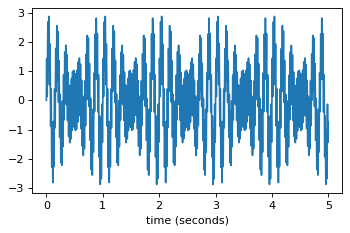

In [ ]:
# Plot input
plt.figure(figsize=(5, 3), dpi=80)
plt.clf()
plt.plot(t, x)
plt.xlabel('time (seconds)')
plt.show()

In [ ]:
# OUTPUT
lowcut = 4
highcut = 8
y= butter_bandpass_filter(x, lowcut, highcut, fs, order=5)

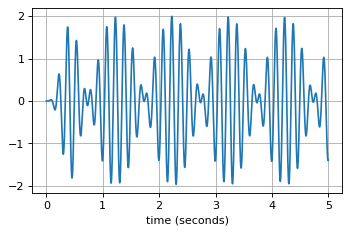

In [ ]:
# Plot output
plt.figure(figsize=(5, 3), dpi=80)
plt.clf()
plt.plot(t, y, label='Filtered signal (%g Hz)' %fs)
plt.xlabel('time (seconds)')
plt.grid(True)
plt.show()

### Filtering EEG signal with Butterworth Band-pass
Following the steps mentioned in [1], there will be 8 band-pass filter with bandwidth of:
1. 4-8Hz
2. 8-12Hz
3. 12-16Hz
4. 16-20Hz
5. 20-24Hz
6. 24-28Hz
7. 28-32Hz
8. 32-36Hz
9. 36-40Hz

*Note*   
Apply filter to the time-series axis, thus set 'raw_EEG' inside each subject to shape of N x T (i.e. electrodes x samples)

In [ ]:
# Transpose all 'raw_EEG' data

for i in range(1, 9):
    if i in [4,5,6,7]:  # Skip subject 4
        continue
    subj = subject_counter(i)

    while mod_data[subj]['raw_EEG'].shape[0] != 22:
        mod_data[subj]['raw_EEG'] = mod_data[subj]['raw_EEG'].T

    print(mod_data[subj]['raw_EEG'].shape)

(22, 672528)
(22, 677169)
(22, 660530)
(22, 675270)


In [ ]:
# Create function that could bandpass filtered one subject
def butter_bandpass_one_subject(data, subj, lowcut, highcut, fs, interval=None):
    print('Processing ', subj)

    # Create new key 'EEG_filtered' to store filtered EEG of each subject
    data[subj]['EEG_filtered'] = {}

    # Current raw EEG
    temp_raw_EEG = data[subj]['raw_EEG']

    if interval is not None:
        startband = np.arange(lowcut, highcut, step = interval)

        for start in startband:
            # This will be new key inside the EEG_filtered
            band = "{:02d}_{:02d}".format(start, start+interval)

            print('Filtering through {} Hz band'.format(band))
            # Bandpass filtering
            data[subj]['EEG_filtered'][band] = {}
            data[subj]['EEG_filtered'][band]['EEG_all'] = butter_bandpass_filter(temp_raw_EEG, start, start+interval, fs)

    else:
        # This will be new key inside the EEG_filtered
        band = "{:02d}_{:02d}".format(lowcut, highcut)

        data[subj]['EEG_filtered'][band]['EEG_all'] = butter_bandpass_filter(temp_raw_EEG, lowcut, highcut, fs)

In [ ]:
# Bandpass filtering all subject
lowcut=4
highcut=40
fs = 250

# Iterate over all subjects

for i in range(1, 9):
    if i in [4,5,6,7]:  # Skip subject 4
        continue
    subj = subject_counter(i)
    butter_bandpass_one_subject(mod_data, subj, lowcut, highcut, fs, interval=4)
    print('')

Processing  subject01
Filtering through 04_08 Hz band
Filtering through 08_12 Hz band
Filtering through 12_16 Hz band
Filtering through 16_20 Hz band
Filtering through 20_24 Hz band
Filtering through 24_28 Hz band
Filtering through 28_32 Hz band
Filtering through 32_36 Hz band
Filtering through 36_40 Hz band

Processing  subject02
Filtering through 04_08 Hz band
Filtering through 08_12 Hz band
Filtering through 12_16 Hz band
Filtering through 16_20 Hz band
Filtering through 20_24 Hz band
Filtering through 24_28 Hz band
Filtering through 28_32 Hz band
Filtering through 32_36 Hz band
Filtering through 36_40 Hz band

Processing  subject03
Filtering through 04_08 Hz band
Filtering through 08_12 Hz band
Filtering through 12_16 Hz band
Filtering through 16_20 Hz band
Filtering through 20_24 Hz band
Filtering through 24_28 Hz band
Filtering through 28_32 Hz band
Filtering through 32_36 Hz band
Filtering through 36_40 Hz band

Processing  subject08
Filtering through 04_08 Hz band
Filtering thr

## Taking EEG data corresponds to left and right class
This work will only clasify two class, left and right hand, meanwhile the data contains four class,  
thus the goal here is to make band-filtered EEG left and right of each class of shape T x C x N, where  
T = trial, C = channel, N = sample

In [ ]:
# First take the position of left and right class
left_class_code = 769
right_class_code = 770

for i in range(1, 9):
    if i in [4,5,6,7]:  # Skip subject 4
        continue
    subj = subject_counter(i)

    mod_data[subj]['left_pos'] = ori_data[subj]['epos'][ori_data[subj]['etyp'] == left_class_code]
    mod_data[subj]['right_pos'] = ori_data[subj]['epos'][ori_data[subj]['etyp'] == right_class_code]

In [ ]:
# Now take EEG data within [0.5 3.5] seconds after cue onset position of each class
start = 0.5
end = 3.5

# Please modify this range to add more subject

for i in range(1, 9):
    if i in [4,5,6,7]:  # Skip subject 4
        continue
    subj = subject_counter(i)
    print('Processing ', subj)
    # Temporary variable of left and right pos
    temp_pos_left = mod_data[subj]['left_pos']
    temp_pos_right = mod_data[subj]['right_pos']

    for band in mod_data[subj]['EEG_filtered'].keys():
        temp_EEG_all = mod_data[subj]['EEG_filtered'][band]['EEG_all']
        temp_EEG_left = []
        temp_EEG_right = []

        # LEFT
        for j in range(len(temp_pos_left)):
            temp_EEG_left.append(temp_EEG_all[:, temp_pos_left[j] + int(start*fs) : temp_pos_left[j] + int(end*fs)])
        mod_data[subj]['EEG_filtered'][band]['EEG_left'] = np.array(temp_EEG_left)

        # RIGHT
        for j in range(len(temp_pos_right)):
            temp_EEG_right.append(temp_EEG_all[:, temp_pos_right[j] + int(start*fs) : temp_pos_right[j] + int(end*fs)])
        mod_data[subj]['EEG_filtered'][band]['EEG_right'] = np.array(temp_EEG_right)

Processing  subject01
Processing  subject02
Processing  subject03
Processing  subject08


# Train/Test Data Split

In [ ]:
def split_EEG_one_class(EEG_one_class, percent_train=0.8):
    '''
    split_EEG_one_class will receive EEG data of one class, with size of T x N x M, where
    T = number of trial
    N = number of electrodes
    M = sample number

    INPUT:
    EEG_data_one_class: the data of one class of EEG data

    percent_train: allocation percentage of training data, default is 0.8

    OUTPUT:
    EEG_train: EEG data for training

    EEG_test: EEG data for test

    Both have type of np.arrray dimension of T x M x N
    '''

    # Number of all trials
    n = EEG_one_class.shape[0]

    n_tr = round(n*percent_train)
    n_te = n - n_tr

    EEG_train = EEG_one_class[:n_tr]
    EEG_test = EEG_one_class[n_tr:n_tr+n_te]

    return EEG_train, EEG_test

In [ ]:
# Iterate over all subjects

for i in range(1, 9):
    if i in [4,5,6,7]:  # Skip subject 4
        continue
    subj = subject_counter(i)

    # Iterate over all bands
    for band in mod_data[subj]['EEG_filtered'].keys():

        # Temporary variable for left and right class of each band
        temp_EEG_left = mod_data[subj]['EEG_filtered'][band]['EEG_left']
        temp_EEG_right = mod_data[subj]['EEG_filtered'][band]['EEG_right']
        print(len(temp_EEG_left))
        print(len(temp_EEG_right))

        # Temporary variable to access each band
        temp_filt = mod_data[subj]['EEG_filtered'][band]

        temp_filt['EEG_left_train'], temp_filt['EEG_left_test'] = split_EEG_one_class(temp_EEG_left, 0.8)
        temp_filt['EEG_right_train'], temp_filt['EEG_right_test'] = split_EEG_one_class(temp_EEG_right, 0.8)
        print(len(temp_filt))
        print(len(temp_filt))

72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7
72
72
7
7


In [ ]:
mod_data['subject01']['EEG_filtered']['04_08'].keys()

dict_keys(['EEG_all', 'EEG_left', 'EEG_right', 'EEG_left_train', 'EEG_left_test', 'EEG_right_train', 'EEG_right_test'])

In [ ]:
print(subj)

subject08


In [ ]:

X_train = np.concatenate((mod_data[subj]['EEG_filtered'][band]['EEG_left_train'],
                         mod_data[subj]['EEG_filtered'][band]['EEG_right_train']), axis=0)
y_train = np.concatenate((np.zeros(mod_data[subj]['EEG_filtered'][band]['EEG_left_train'].shape[0]),
                         np.ones(mod_data[subj]['EEG_filtered'][band]['EEG_right_train'].shape[0])), axis=0)

# Do the same for test data
X_test=np.concatenate((mod_data[subj]['EEG_filtered'][band]['EEG_left_test'],
                       mod_data[subj]['EEG_filtered'][band]['EEG_right_test']), axis=0)
Y_test=np.concatenate((np.zeros(mod_data[subj]['EEG_filtered'][band]['EEG_left_test'].shape[0]),
                       np.ones(mod_data[subj]['EEG_filtered'][band]['EEG_right_test'].shape[0])), axis=0)

In [ ]:
import torch
import numpy as np

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(Y_test, dtype=torch.long)


In [ ]:
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []


for i in range(1, 9):
    if i in [4,5,6,7]:  # Skip subject 4
        continue
    subj = subject_counter(i)
    for band in mod_data[subj]['EEG_filtered'].keys():
        # process as currently done
        X_train_list.append(np.concatenate((mod_data[subj]['EEG_filtered'][band]['EEG_left_train'],
                                            mod_data[subj]['EEG_filtered'][band]['EEG_right_train']), axis=0))
        y_train_list.append(np.concatenate((np.zeros(mod_data[subj]['EEG_filtered'][band]['EEG_left_train'].shape[0]),
                                            np.ones(mod_data[subj]['EEG_filtered'][band]['EEG_right_train'].shape[0])), axis=0))
        X_test_list.append(np.concatenate((mod_data[subj]['EEG_filtered'][band]['EEG_left_test'],
                                           mod_data[subj]['EEG_filtered'][band]['EEG_right_test']), axis=0))
        y_test_list.append(np.concatenate((np.zeros(mod_data[subj]['EEG_filtered'][band]['EEG_left_test'].shape[0]),
                                           np.ones(mod_data[subj]['EEG_filtered'][band]['EEG_right_test'].shape[0])), axis=0))

# Finally, concatenate all list elements into single arrays
X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
X_test = np.concatenate(X_test_list, axis=0)
Y_test = np.concatenate(y_test_list, axis=0)


In [ ]:
import torch
import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.batch_norm = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        # Initialize the hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)

        # Apply batch normalization
        out = self.batch_norm(out[:, -1, :])

        # Apply dropout
        out = self.dropout(out)

        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out


In [ ]:
from torch.utils.data import Dataset, DataLoader

class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset and dataloader
train_dataset = EEGDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = EEGDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    test_running_corrects = 0
    test_total_samples = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.to(device))
            test_running_corrects += (outputs.argmax(1) == labels.to(device)).sum().item()
            test_total_samples += labels.size(0)

    test_acc = test_running_corrects / test_total_samples
    return test_acc

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Hyperparameters
input_size = X_train_tensor.shape[2]  # Number of features (channels)
hidden_size = 256
num_layers = 2
num_classes = 2
num_epochs = 50  # Set higher and use early stopping
learning_rate = 0.001
patience = 10  # Early stopping patience

# Determine the device to be used (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, loss function, and optimizer
model = SimpleRNN(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)  # Add weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Early stopping parameters
best_test_loss = float('inf')
early_stopping_counter = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        running_corrects += (outputs.argmax(1) == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    # Test loop for early stopping
    model.eval()
    test_loss = 0.0
    test_corrects = 0
    test_samples = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            test_corrects += (outputs.argmax(1) == labels).sum().item()
            test_samples += labels.size(0)

    test_loss /= test_samples
    test_acc = test_corrects / test_samples
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    # Scheduler step
    scheduler.step(test_loss)

    # Early stopping check
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping")
            break

# Final evaluation using the test loader
best_model = SimpleRNN(input_size, hidden_size, num_layers, num_classes).to(device)
best_model.load_state_dict(torch.load('best_model.pt'))
test_accuracy = evaluate_model(best_model, test_loader)
print(f'Final Test Accuracy: {test_accuracy:.4f}')


Epoch [1/50], Loss: 0.8106, Accuracy: 0.5690
Test Loss: 0.6530, Test Accuracy: 0.6071
Epoch [2/50], Loss: 0.6039, Accuracy: 0.6897
Test Loss: 0.6844, Test Accuracy: 0.5357
Epoch [3/50], Loss: 0.4486, Accuracy: 0.7845
Test Loss: 0.8104, Test Accuracy: 0.4643
Epoch [4/50], Loss: 0.4065, Accuracy: 0.8103
Test Loss: 0.7678, Test Accuracy: 0.5357
Epoch [5/50], Loss: 0.2653, Accuracy: 0.8966
Test Loss: 0.7922, Test Accuracy: 0.5714
Epoch [6/50], Loss: 0.1880, Accuracy: 0.9224
Test Loss: 0.9902, Test Accuracy: 0.6429
Epoch [7/50], Loss: 0.1079, Accuracy: 0.9741
Test Loss: 1.2180, Test Accuracy: 0.6071
Epoch [8/50], Loss: 0.0609, Accuracy: 0.9914
Test Loss: 1.3824, Test Accuracy: 0.5714
Epoch [9/50], Loss: 0.0391, Accuracy: 1.0000
Test Loss: 1.6243, Test Accuracy: 0.5714
Epoch [10/50], Loss: 0.0428, Accuracy: 1.0000
Test Loss: 1.7276, Test Accuracy: 0.6071
Epoch [11/50], Loss: 0.0268, Accuracy: 0.9914
Test Loss: 1.8104, Test Accuracy: 0.6071
Early stopping
Final Test Accuracy: 0.6071


In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import itertools
# from sklearn.model_selection import train_test_split
# from torch.utils.data import DataLoader, TensorDataset
# import numpy as np

# # Hyperparameter grid
# input_size = X_train_tensor.shape[2]  # Number of features (channels)
# hidden_sizes = [64, 128, 256, 512]
# num_layers_list = [1, 2, 3]
# learning_rates = [0.0001, 0.001, 0.01]
# weight_decays = [1e-3, 1e-4, 1e-5, 1e-6]
# num_epochs = 15
# num_seeds = 50  # Number of different seeds to use for averaging
# patience = 5  # Early stopping patience
# improvement_threshold = 0.001  # Minimum improvement to be considered as significant

# # Split data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_train_tensor, y_train_tensor, test_size=0.2, random_state=42)
# train_dataset = TensorDataset(X_train, y_train)
# val_dataset = TensorDataset(X_val, y_val)

# best_acc = 0.0
# best_params = {}
# best_seed_accuracies = []

# worst_acc = float('inf')
# worst_params = {}
# worst_seed_accuracies = []

# # Function to set seed for reproducibility
# def set_seed(seed):
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     np.random.seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

# # Function to evaluate the model
# def evaluate_model(model, data_loader, criterion, device):
#     model.eval()
#     total_loss = 0.0
#     corrects = 0
#     total_samples = 0
#     with torch.no_grad():
#         for inputs, labels in data_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             total_loss += loss.item() * inputs.size(0)
#             corrects += (outputs.argmax(1) == labels).sum().item()
#             total_samples += labels.size(0)
#     avg_loss = total_loss / total_samples
#     avg_acc = corrects / total_samples
#     return avg_loss, avg_acc

# # Device configuration
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Grid Search
# for hidden_size, num_layers, learning_rate, weight_decay in itertools.product(hidden_sizes, num_layers_list, learning_rates, weight_decays):
#     seed_accuracies = []

#     for seed in range(num_seeds):
#         set_seed(seed)
#         train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#         val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

#         model = SimpleRNN(input_size, hidden_size, num_layers, num_classes).to(device)
#         criterion = nn.CrossEntropyLoss()
#         optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#         scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience, factor=0.5)

#         best_val_loss = float('inf')
#         early_stopping_counter = 0

#         for epoch in range(num_epochs):
#             model.train()
#             running_loss = 0.0
#             running_corrects = 0
#             total_samples = 0

#             for inputs, labels in train_loader:
#                 inputs, labels = inputs.to(device), labels.to(device)

#                 # Forward pass
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)

#                 # Backward pass and optimization
#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()

#                 # Calculate loss and accuracy
#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += (outputs.argmax(1) == labels).sum().item()
#                 total_samples += labels.size(0)

#             epoch_loss = running_loss / total_samples
#             epoch_acc = running_corrects / total_samples

#             # Validation loop for early stopping
#             val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
#             print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

#             # Scheduler step
#             scheduler.step(val_loss)

#             # Early stopping check
#             if val_loss < best_val_loss - improvement_threshold:
#                 best_val_loss = val_loss
#                 early_stopping_counter = 0
#                 torch.save(model.state_dict(), 'best_model.pt')
#             else:
#                 early_stopping_counter += 1
#                 if early_stopping_counter >= patience:
#                     print("Early stopping")
#                     break

#         # Load the best model for evaluation
#         best_model = SimpleRNN(input_size, hidden_size, num_layers, num_classes).to(device)
#         best_model.load_state_dict(torch.load('best_model.pt'))
#         val_loss, val_acc = evaluate_model(best_model, val_loader, criterion, device)
#         seed_accuracies.append(val_acc)

#     avg_val_acc = np.mean(seed_accuracies)
#     var_val_acc = np.var(seed_accuracies)

#     if avg_val_acc > best_acc:
#         best_acc = avg_val_acc
#         best_params = {
#             'hidden_size': hidden_size,
#             'num_layers': num_layers,
#             'learning_rate': learning_rate,
#             'weight_decay': weight_decay
#         }
#         best_seed_accuracies = seed_accuracies.copy()

#     if avg_val_acc < worst_acc:
#         worst_acc = avg_val_acc
#         worst_params = {
#             'hidden_size': hidden_size,
#             'num_layers': num_layers,
#             'learning_rate': learning_rate,
#             'weight_decay': weight_decay
#         }
#         worst_seed_accuracies = seed_accuracies.copy()

#     print(f'Params: hidden_size={hidden_size}, num_layers={num_layers}, learning_rate={learning_rate}, Avg Val Accuracy: {avg_val_acc:.4f}, Var Val Accuracy: {var_val_acc:.4f}')

# # Calculate mean and variance for best and worst params
# best_mean_acc = np.mean(best_seed_accuracies)
# best_var_acc = np.var(best_seed_accuracies)
# worst_mean_acc = np.mean(worst_seed_accuracies)
# worst_var_acc = np.var(worst_seed_accuracies)

# print(f'Best params: {best_params}, Best average validation accuracy: {best_acc:.4f}, Mean Accuracy: {best_mean_acc:.4f}, Variance: {best_var_acc:.4f}')
# print(f'Worst params: {worst_params}, Worst average validation accuracy: {worst_acc:.4f}, Mean Accuracy: {worst_mean_acc:.4f}, Variance: {worst_var_acc:.4f}')


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
def evaluate_model(model, test_loader):
    model.eval()
    test_running_corrects = 0
    test_total_samples = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.to(device))
            test_running_corrects += (outputs.argmax(1) == labels.to(device)).sum().item()
            test_total_samples += labels.size(0)

    test_acc = test_running_corrects / test_total_samples
    return test_acc
# Hyperparameters
input_size = X_train_tensor.shape[2]  # Number of features (channels)
hidden_size = 256
num_layers = 3
num_classes = 2
num_epochs = 50  # Set higher and use early stopping
learning_rate = 0.001
patience = 5  # Early stopping patience

# Determine the device to be used (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, loss function, and optimizer
model = SimpleRNN(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)  # Add weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Early stopping parameters
best_test_loss = float('inf')
early_stopping_counter = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        running_corrects += (outputs.argmax(1) == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    # Test loop for early stopping
    model.eval()
    test_loss = 0.0
    test_corrects = 0
    test_samples = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            test_corrects += (outputs.argmax(1) == labels).sum().item()
            test_samples += labels.size(0)

    test_loss /= test_samples
    test_acc = test_corrects / test_samples
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    # Scheduler step
    scheduler.step(test_loss)

    # Early stopping check
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping")
            break

# Final evaluation using the test loader
best_model = SimpleRNN(input_size, hidden_size, num_layers, num_classes).to(device)
best_model.load_state_dict(torch.load('best_model.pt'))
test_accuracy = evaluate_model(best_model, test_loader)
print(f'Final Test Accuracy: {test_accuracy:.4f}')


Epoch [1/50], Loss: 0.9229, Accuracy: 0.5431
Test Loss: 0.6806, Test Accuracy: 0.5714
Epoch [2/50], Loss: 0.8296, Accuracy: 0.5862
Test Loss: 0.6859, Test Accuracy: 0.5000
Epoch [3/50], Loss: 0.5391, Accuracy: 0.7241
Test Loss: 0.6666, Test Accuracy: 0.6071
Epoch [4/50], Loss: 0.5192, Accuracy: 0.7586
Test Loss: 0.7021, Test Accuracy: 0.6786
Epoch [5/50], Loss: 0.3171, Accuracy: 0.8966
Test Loss: 0.7388, Test Accuracy: 0.6429
Epoch [6/50], Loss: 0.2576, Accuracy: 0.9052
Test Loss: 0.9116, Test Accuracy: 0.6786
Epoch [7/50], Loss: 0.1352, Accuracy: 0.9569
Test Loss: 1.2264, Test Accuracy: 0.6071
Epoch [8/50], Loss: 0.0959, Accuracy: 0.9569
Test Loss: 1.5894, Test Accuracy: 0.5357
Early stopping
Final Test Accuracy: 0.6071


In [ ]:
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []


for i in range(1, 9):
    if i in [4,5,6,7]:  # Skip subject 4
        continue
    subj = subject_counter(i)
    for band in mod_data[subj]['EEG_filtered'].keys():
        # process as currently done
        X_train_list.append(np.concatenate((mod_data[subj]['EEG_filtered'][band]['EEG_left_train'],
                                            mod_data[subj]['EEG_filtered'][band]['EEG_right_train']), axis=0))
        y_train_list.append(np.concatenate((np.zeros(mod_data[subj]['EEG_filtered'][band]['EEG_left_train'].shape[0]),
                                            np.ones(mod_data[subj]['EEG_filtered'][band]['EEG_right_train'].shape[0])), axis=0))
        X_test_list.append(np.concatenate((mod_data[subj]['EEG_filtered'][band]['EEG_left_test'],
                                           mod_data[subj]['EEG_filtered'][band]['EEG_right_test']), axis=0))
        y_test_list.append(np.concatenate((np.zeros(mod_data[subj]['EEG_filtered'][band]['EEG_left_test'].shape[0]),
                                           np.ones(mod_data[subj]['EEG_filtered'][band]['EEG_right_test'].shape[0])), axis=0))

# Finally, concatenate all list elements into single arrays
X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
X_test = np.concatenate(X_test_list, axis=0)
Y_test = np.concatenate(y_test_list, axis=0)
import torch
import numpy as np

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

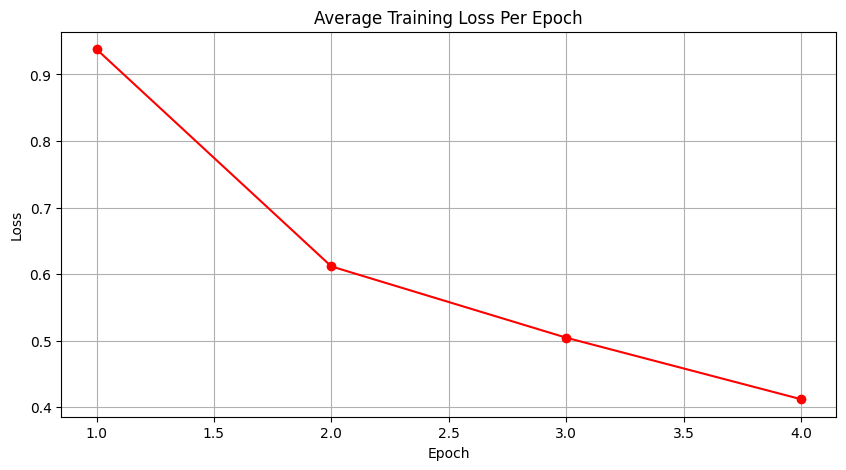

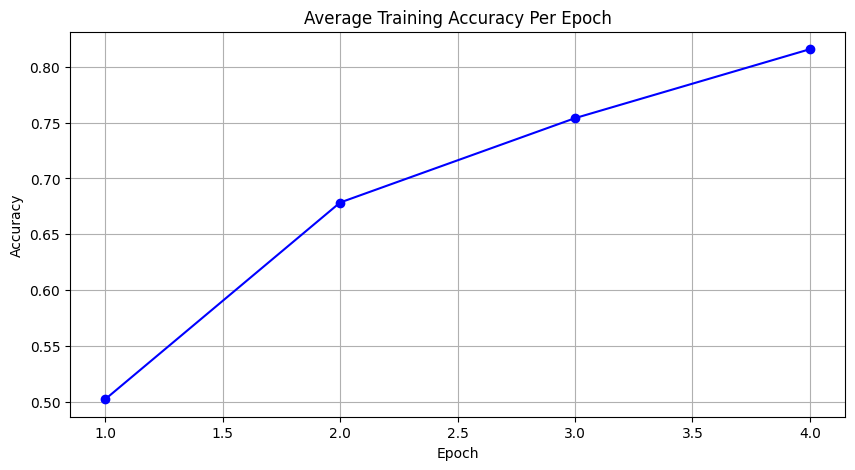

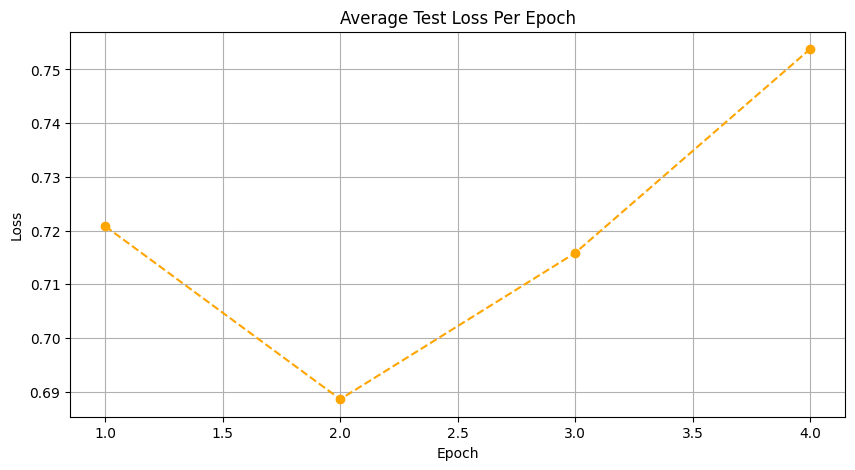

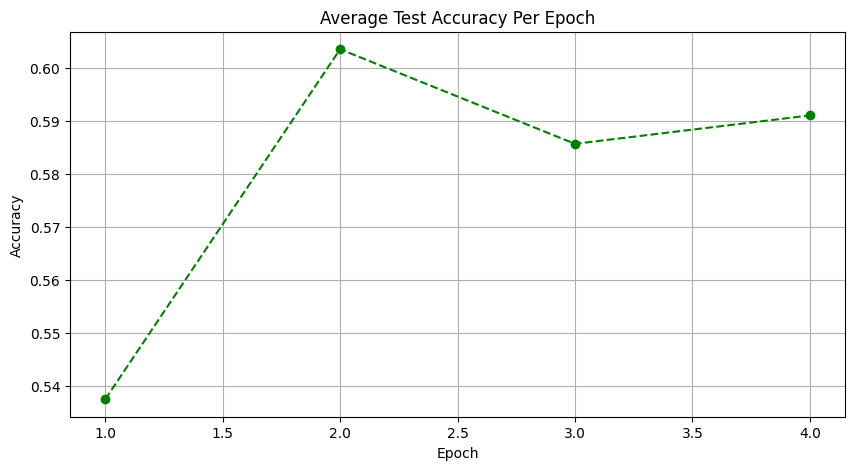

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

def run_experiments(train_loader, test_loader):

    # Hyperparameters
    input_size = X_train_tensor.shape[2]  # Number of features (channels)
    hidden_size = 256
    num_layers = 2
    num_classes = 2
    num_epochs = 4
    learning_rate = 0.001

    num_runs = 20
    final_test_accuracies = []  # To store the last epoch test accuracies of each run

    all_epoch_accuracies = np.zeros((num_epochs,))  # Storing average accuracies per epoch across all runs
    all_epoch_losses = np.zeros((num_epochs,))     # Storing average losses per epoch across all runs
    all_test_accuracies = np.zeros((num_epochs,))  # Storing average test accuracies per epoch across all runs
    all_test_losses = np.zeros((num_epochs,))      # Storing average test losses per epoch across all runs

    for run in range(num_runs):

        # Model, loss function, and optimizer
        model = SimpleRNN(input_size, hidden_size, num_layers, num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Lists to store metrics information
        epoch_losses = []
        epoch_accuracies = []
        test_epoch_losses = []
        test_epoch_accuracies = []

        # print(f'Run {run + 1}/{num_runs}')

        # Training loop with accuracy and loss calculation
        for epoch in range(num_epochs):
            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            model.train()

            for i, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Calculate loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += (outputs.argmax(1) == labels).sum().item()
                total_samples += labels.size(0)

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / total_samples

            # Store metrics for plotting
            epoch_losses.append(epoch_loss)
            epoch_accuracies.append(epoch_acc)

            # Test the model
            model.eval()
            test_loss = 0.0
            test_corrects = 0
            test_samples = 0

            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    test_loss += loss.item() * inputs.size(0)
                    test_corrects += (outputs.argmax(1) == labels).sum().item()
                    test_samples += labels.size(0)

            test_epoch_loss = test_loss / test_samples
            test_epoch_accuracy = test_corrects / test_samples

            test_epoch_losses.append(test_epoch_loss)
            test_epoch_accuracies.append(test_epoch_accuracy)

        # Store the last epoch test accuracy of each run
        final_test_accuracies.append(test_epoch_accuracies[-1])

        # Aggregate data across runs
        all_epoch_losses += np.array(epoch_losses)
        all_epoch_accuracies += np.array(epoch_accuracies)
        all_test_losses += np.array(test_epoch_losses)
        all_test_accuracies += np.array(test_epoch_accuracies)

    # Average the metrics over all runs
    all_epoch_losses /= num_runs
    all_epoch_accuracies /= num_runs
    all_test_losses /= num_runs
    all_test_accuracies /= num_runs

    # Calculate average and variance of the final epoch test accuracies
    average_final_test_accuracy = np.mean(final_test_accuracies)
    variance_final_test_accuracy = np.var(final_test_accuracies)

    # Plotting training loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), all_epoch_losses, marker='o', color='red')
    plt.title('Average Training Loss Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    # Plotting training accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), all_epoch_accuracies, marker='o', color='blue')
    plt.title('Average Training Accuracy Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

    # Plotting test loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), all_test_losses, marker='o', linestyle='--', color='orange')
    plt.title('Average Test Loss Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    # Plotting test accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), all_test_accuracies, marker='o', linestyle='--', color='green')
    plt.title('Average Test Accuracy Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

    return average_final_test_accuracy, variance_final_test_accuracy

# Call your function with appropriate loaders
avg_final_test_accuracy, var_final_test_accuracy = run_experiments(train_loader, test_loader)


In [ ]:
print(avg_final_test_accuracy, var_final_test_accuracy)

0.5910714285714287 0.004652423469387757


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

def run_experiments(train_loader, test_loader):

    # Hyperparameters
    input_size = X_train_tensor.shape[2]  # Number of features (channels)
    hidden_size = 256
    num_layers = 2
    num_classes = 2
    num_epochs = 4
    learning_rate = 0.001

    num_runs = 20
    final_test_accuracies = []  # To store the last epoch test accuracies of each run

    all_epoch_accuracies = np.zeros((num_epochs,))  # Storing average accuracies per epoch across all runs
    all_epoch_losses = np.zeros((num_epochs,))     # Storing average losses per epoch across all runs
    all_test_accuracies = np.zeros((num_epochs,))  # Storing average test accuracies per epoch across all runs
    all_test_losses = np.zeros((num_epochs,))      # Storing average test losses per epoch across all runs

    for run in range(num_runs):

        # Model, loss function, and optimizer
        model = SimpleRNN(input_size, hidden_size, num_layers, num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Lists to store metrics information
        epoch_losses = []
        epoch_accuracies = []
        test_epoch_losses = []
        test_epoch_accuracies = []

        # print(f'Run {run + 1}/{num_runs}')

        # Training loop with accuracy and loss calculation
        for epoch in range(num_epochs):
            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            model.train()

            for i, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Calculate loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += (outputs.argmax(1) == labels).sum().item()
                total_samples += labels.size(0)

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / total_samples

            # Store metrics for plotting
            epoch_losses.append(epoch_loss)
            epoch_accuracies.append(epoch_acc)

            # Test the model
            model.eval()
            test_loss = 0.0
            test_corrects = 0
            test_samples = 0

            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    test_loss += loss.item() * inputs.size(0)
                    test_corrects += (outputs.argmax(1) == labels).sum().item()
                    test_samples += labels.size(0)

            test_epoch_loss = test_loss / test_samples
            test_epoch_accuracy = test_corrects / test_samples

            test_epoch_losses.append(test_epoch_loss)
            test_epoch_accuracies.append(test_epoch_accuracy)

        # Store the last epoch test accuracy of each run
        final_test_accuracies.append(test_epoch_accuracies[-1])

        # Aggregate data across runs
        all_epoch_losses += np.array(epoch_losses)
        all_epoch_accuracies += np.array(epoch_accuracies)
        all_test_losses += np.array(test_epoch_losses)
        all_test_accuracies += np.array(test_epoch_accuracies)

    # Average the metrics over all runs
    all_epoch_losses /= num_runs
    all_epoch_accuracies /= num_runs
    all_test_losses /= num_runs
    all_test_accuracies /= num_runs

    # Calculate average and variance of the final epoch test accuracies
    average_final_test_accuracy = np.mean(final_test_accuracies)
    variance_final_test_accuracy = np.var(final_test_accuracies)

    return average_final_test_accuracy, variance_final_test_accuracy

# Call your function with appropriate loaders
# avg_final_test_accuracy, var_final_test_accuracy = run_experiments(train_loader, test_loader)


In [ ]:
import numpy as np

def prepare_data_for_subject(mod_data, subject):
    X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

    for band in mod_data[subject]['EEG_filtered'].keys():
        X_train_list.append(np.concatenate((mod_data[subject]['EEG_filtered'][band]['EEG_left_train'],
                                            mod_data[subject]['EEG_filtered'][band]['EEG_right_train']), axis=0))
        y_train_list.append(np.concatenate((np.zeros(mod_data[subject]['EEG_filtered'][band]['EEG_left_train'].shape[0]),
                                            np.ones(mod_data[subject]['EEG_filtered'][band]['EEG_right_train'].shape[0])), axis=0))
        X_test_list.append(np.concatenate((mod_data[subject]['EEG_filtered'][band]['EEG_left_test'],
                                           mod_data[subject]['EEG_filtered'][band]['EEG_right_test']), axis=0))
        y_test_list.append(np.concatenate((np.zeros(mod_data[subject]['EEG_filtered'][band]['EEG_left_test'].shape[0]),
                                           np.ones(mod_data[subject]['EEG_filtered'][band]['EEG_right_test'].shape[0])), axis=0))

    # Concatenate all list elements into single arrays
    X_train = np.concatenate(X_train_list, axis=0)
    y_train = np.concatenate(y_train_list, axis=0)
    X_test = np.concatenate(X_test_list, axis=0)
    Y_test = np.concatenate(y_test_list, axis=0)

    return X_train, y_train, X_test, Y_test


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

subject_results = []


for i in range(1, 9):
    if i in [4,5,6,7]:  # Skip subject 4
        continue
    print("subject",i)
    subject = subject_counter(i)
    X_train, y_train, X_test, Y_test = prepare_data_for_subject(mod_data, subject)

    # Convert numpy arrays to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

    # Create dataset and dataloader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Run experiments
    mean_accuracy, variance_accuracy = run_experiments(train_loader, test_loader)

    subject_results.append(mean_accuracy)
    print(f'Results for subject {i}: Mean Accuracy = {mean_accuracy}, Variance = {variance_accuracy}')

# Calculate and print the mean accuracy and variance across all subjects
overall_mean_accuracy = np.mean(subject_results)
overall_variance_accuracy = np.var(subject_results)

print(f'Overall Mean Accuracy Across Subjects: {overall_mean_accuracy:.4f}')
print(f'Overall Variance Across Subjects: {overall_variance_accuracy:.4f}')



subject 1
Results for subject 1: Mean Accuracy = 0.5371031746031746, Variance = 0.000614567586293777
subject 2
Results for subject 2: Mean Accuracy = 0.4992063492063492, Variance = 0.0005001259763164527
subject 3
Results for subject 3: Mean Accuracy = 0.5057539682539682, Variance = 0.0004747338750314944
subject 8
Results for subject 8: Mean Accuracy = 0.5059523809523809, Variance = 0.00025116528092718616
Overall Mean Accuracy Across Subjects: 0.5120
Overall Variance Across Subjects: 0.0002


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

def prepare_combined_data(mod_data, train_subjects, test_subject):
    # Combine training data from multiple subjects
    X_train, y_train = [], []
    for subj in train_subjects:
        subject_data = prepare_data_for_subject(mod_data, subject_counter(subj))
        X_train.append(subject_data[0])  # X_train data
        y_train.append(subject_data[1])  # y_train data

    # Flatten lists and concatenate
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)

    # Prepare test data for the test subject
    X_test, Y_test = prepare_data_for_subject(mod_data, subject_counter(test_subject))[2:]

    return X_train, y_train, X_test, Y_test



# Run experiment: Train and test on subject 5
X_train, y_train, X_test, Y_test = prepare_data_for_subject(mod_data, subject_counter(8))
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Testing self-consistency on subject 5:")
self_results = run_experiments(train_loader, test_loader)




# Run experiment: Train on 1, 2, 3 and test on 5
X_train, y_train, X_test, Y_test = prepare_combined_data(mod_data, [1, 2, 3], 8)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Assuming run_experiments is already defined and set up for one-off training/testing
print("Testing generalization from subjects 1, 2, 3 to subject 8:")
gen_results = run_experiments(train_loader, test_loader)



# Compare results
print(f"Generalization results: {gen_results}")
print(f"Self-consistency results: {self_results}")


Testing self-consistency on subject 5:
Testing generalization from subjects 1, 2, 3 to subject 8:
Generalization results: (0.5170634920634921, 0.0006221655328798189)
Self-consistency results: (0.5057539682539682, 0.0006825947971781309)
